#### **Using Implied Cost of Capital as a Sector ETF Valuation Tool**
#### _[Sunday 4.26.2015]_
------------

***This is a follow-up to these posts [here](http://blkarb.se/1FCBL1R) and [here](http://blkarb.se/1HJ3tsR) where I breakdown in detail the `ICC` methodology used. All the data and plots have been updated and reflects current information. Scroll to the bottom to see the results of our previous predictions.*** 

The following IPython Notebook examines the **Implied Cost of Capital (ICC)** method of valuation for purposes of trade/portfolio positioning. The **ICC** model is a forward looking estimate that uses earnings forecasts to calculate an implied earnings growth rate. The goal of this analysis is to identify asymmetric investing opportunities due to incongruence between *"recent"* historical returns and forward looking expectations of earnings growth (as measured by the ICC). 

**_Please note:_** _there will be some category overlap as some of the groupings include international sector ETF's while other groupings contain regional and/or country ETF's._ 
____

In [1]:
%%javascript
IPython.load_extensions('IPython-notebook-extensions-3.x/usability/runtools/main')

<IPython.core.display.Javascript object>

In [2]:
# ================================================================== #
# composite returns; vol; risk adjusted returns; correlation matrix, ICC analysis

import pandas as p
import numpy as np
import pandas.io.data as web
from pandas.tseries.offsets import *
import datetime as dt
import math
import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
%matplotlib inline
size=(10,8)
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import cufflinks 

# ================================================================== #

date_today = dt.date.today()
month = 'APR-2015'

# ~~~ Market Cap ~~~ #
Broad_mkts = ['THRK','RSCO'] # Russell 3000, Russell Small Cap Completeness
Large_cap  = ['ONEK','SPY','SPYG','SPYV'] # Russell 1000, sp500 (growth, value)
Mid_cap    = ['MDY','MDYG', 'MDYV'] # sp400 mid (growth, value)
Small_cap  = ['TWOK','SLY','SLYG','SLYV'] # russ 2K, sp600, (growth, value)

# ~~~ International/Global Equities ~~~ #
Global = [
        'DGT', #  global dow
        'BIK', # sp BRIC 40 ETF
        'GMM', # sp emerging mkts 
        'EWX', # sp emerging mkts small caps
        'CWI', # msci acwi ex-US
        'GII', # global infrastructure
        'GNR', # global natural resources
        'DWX', # intl dividends
        'GWL', # sp developed world ex-US 
        'MDD', # intl mid cap (2B-5B USD)
        'GWX'  # intl small cap (<2B USD)
        ]

Asia   = ['JPP','JSC','GXC','GMF'] # japan, smallcap japan, china, emg asiapac
Europe = ['FEZ','GUR','RBL','FEU'] # euro stoxx 50, emg europe, russia, stoxx europe 50
Latam  = ['GML'] # emg latin america
Africa = ['GAF'] # emg mideast/africa

# ~~~ Real Assets ~~~ #
Real_assets = [ 'RWO', # global real estate
                'RWX', # intl real estate ex-US
                'RWR'  # US select REIT
                ]        

# ~~~ sectors and industries ETF's ~~~ #
Sector = [
          'XLY','XHB','IPD','XRT',                   # consumer discretionary
          'XLP','IPS',                               # consumer staples
          'XLE','IPW','XES','XOP',                   # energy
          'XLF','KBE','KCE','KIE','IPF','KRE',       # financials
          'XLV','XBI','XHE','XHS','IRY','XPH',       # healthcare
          'XLI','XAR','IPN','XTN',                   # industrial
          'XLB','IRV','XME',                         # materials
          'XLK','MTK','IPK','XSD','XSW',             # technology
          'IST','XTL',                               # telecom
          'IPU','XLU'                                # utilities
          ]
   
stock_list = [Broad_mkts, Large_cap, Mid_cap, Small_cap, Global, Asia, Europe, Latam, Africa, Real_assets, Sector]

# ~~~ Category structure ~~~ #
cat = {'Broad_Market'          :['THRK','RSCO'],
       'Large_Cap'             :['ONEK','SPY','SPYG','SPYV'],
       'Mid_Cap'               :['MDY','MDYG', 'MDYV'], 
       'Small_Cap'             :['TWOK','SLY','SLYG','SLYV'],
       'Global_Equity'         :['DGT','BIK','GMM','EWX','CWI','GII','GNR','DWX','GWL','MDD','GWX'],
       'AsiaPac_Equity'        :['JPP','JSC','GXC','GMF'],
       'Europe_Equity'         :['FEZ','GUR','RBL','FEU'],
       'Latam_MidEast_Africa'  :['GML','GAF'],
       'Real_Estate'           :['RWO','RWX','RWR'],
       'Consumer_Discretionary':['XLY','XHB','IPD','XRT'],
       'Consumer_Staples'      :['XLP','IPS'],                         
       'Energy'                :['XLE','IPW','XES','XOP'],                   
       'Financials'            :['XLF','KBE','KCE','KIE','IPF','KRE'],
       'Healthcare'            :['XLV','XBI','XHE','XHS','IRY','XPH'],
       'Industrial'            :['XLI','XAR','IPN','XTN'],
       'Materials'             :['XLB','IRV','XME'],
       'Technology'            :['XLK','MTK','IPK','XSD','XSW'],
       'Telecom'               :['IST','XTL'],                            
       'Utilities'             :['IPU','XLU']
        }    

filepath   = r'C:\Users\Owner\Documents\Visual_Studio_2013\Projects\iVC_Reporting_Engine\PythonApplication2\\'

In [3]:
# ================================================================== #
# get prices
def get_px(stock, start, end):
    '''
    Function to call Pandas' Yahoo Finance API to get daily stock prices.
    
    Parameters:
    ==========
    stock = type('str'); stock symbol 
    start = 3 business days before today; datetime date_today object offset by pandas.DateOffset method 
    end   = today; datetime date_today object

    Returns:
    ========
    time series = Pandas.Series object corresponding to stock symbol, and start/end dates
    **Note that if price column is not specified the function will return a Pandas.DataFrame object
    '''      
    try:
        return web.DataReader(stock, 'yahoo', start, end)['Adj Close']
    except Exception as e:
        print( 'something is fucking up' )

px = p.DataFrame()
for category in stock_list:
    for stock in category:
        px[stock] = get_px( stock, date_today - 252 * BDay(), date_today )
        
# ================================================================== #
# construct dataframe and proper multi index
log_rets = np.log( px / px.shift(1) ).dropna()

lrets = log_rets.T.copy()
lrets.index.name = 'ETF'
lrets['Category'] = p.Series()

for cat_key, etf_val in cat.items():
    for val in etf_val:
        if val in lrets.index:
            idx_loc = lrets.index.get_loc(val)
            lrets.ix[idx_loc,'Category'] = cat_key
        else:
            pass

lrets.set_index('Category', append=True, inplace=True)
lrets = lrets.swaplevel('ETF','Category').sortlevel('Category')
lrets.head()       

# ================================================================== #
# cumulative returns of ETF's
cum_rets = lrets.groupby(level='Category').cumsum(axis=1)
cum_rets.head()

# ================================================================== #
# composite groupings of cumulative ETF returns (equally weighted intra-category mean returns)
composite_rets = p.DataFrame()
for label in cat.keys():
    composite_rets[label] = cum_rets.ix[label].mean(axis=0) # equal weighted mean
    
comp_rets = np.round(composite_rets.copy(),4) # rounding


In [4]:
# ~~~~~ plot code ~~~~~ 
# function to create Plotly 'Layout' object

def create_layout( main_title, y_title ):
    '''
    Function to create custom Plotly layout object to pass to Cufflinks df.iplot() method
    
    Parameters:
    ==========
    
    main_title = type('str')
    y_title    = type('str')

    Returns:
    ========
    plotly_layout = Plotly Layout object basically constructed using a JSON or Dict structure    
    '''    
    plotly_layout = Layout(
        # ~~~~ construct main title
            title=main_title,
            font=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
        # ~~~~ construct X axis
        xaxis=XAxis(
            title='$Date$',
            titlefont=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
            showticklabels=True,
            tickangle=-30,
            tickfont=Font(
                family='Open Sans, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'
        ),
        # ~~~~ construct Y axis
        yaxis=YAxis(
            title= y_title,
            titlefont=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
            showticklabels=True,
            tickangle=0,
            tickfont=Font(
                family='Open Sans, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'),
        # ~~~~ construct figure size
            autosize=False,
            width=850,
            height=500,
            margin=Margin(
            l=50,
            r=20,
            b=60,
            t=50,
            pad=2
            ),
        # ~~~~ construct legend      
            legend=Legend(
            y=0.5,
            #traceorder='reversed',
            font=Font(
                family='Open Sans, sans-serif',
                size=9,
                color='Black'
        ),            
        )
    )
    return plotly_layout

In [5]:
# test the function
title = '<b>Cumulative Log Returns of Composite ETF Sectors [1 Year]</b>'
y_label = '$Returns$'

custom_layout_1 = create_layout( title, y_label )
comp_rets.iplot(theme='white',filename='{}_{}'.format(title, date_today), layout=custom_layout_1, world_readable=True)

In [6]:
# ================================================================== #
# composite rolling std

sigmas = lrets.groupby(level='Category').std() # equal weighted std

composite_sigs = p.DataFrame()
for label in cat.keys():
    composite_sigs[label] = sigmas.ix[label] 

rsigs = p.rolling_mean( composite_sigs, window=60 ).dropna()*math.sqrt(60)

# ~~~~~ plot code
title = '<b>60-Day Moving Average of Standard Deviation</b>'
#y_label = r'$return \ \sigma$'
y_label = r'$\sigma \ of \ returns$'

custom_layout_2 = create_layout( title, y_label )
rsigs.iplot(theme='white',filename='{}_{}'.format(title, date_today), layout=custom_layout_2, world_readable=True)

In [7]:
# ================================================================== #
# composite rolling risk adjusted returns

mean_rets = lrets.groupby(level='Category').mean() # equal weighted mean
#risk_rets = (mean_rets-lrets.loc['Global_Equity','DGT'])/sigmas
#risk_rets = mean_rets/sigmas

composite_risk_rets = p.DataFrame()
for label in cat.keys():
    composite_risk_rets[label] = mean_rets.ix[label] 

rs = p.rolling_mean( composite_risk_rets, window=60 ).dropna() 
risk_rets = rs/rsigs

# ~~~~~ plot code
title = r'<b>60 day Moving Average of Composite Risk-Adjusted Returns</b>'
y_label = '$\mu/\sigma$$'

custom_layout_3 = create_layout( title, y_label )
risk_rets.iplot(theme='white', filename='{}_{}'.format(title, date_today), layout=custom_layout_3, world_readable=True)

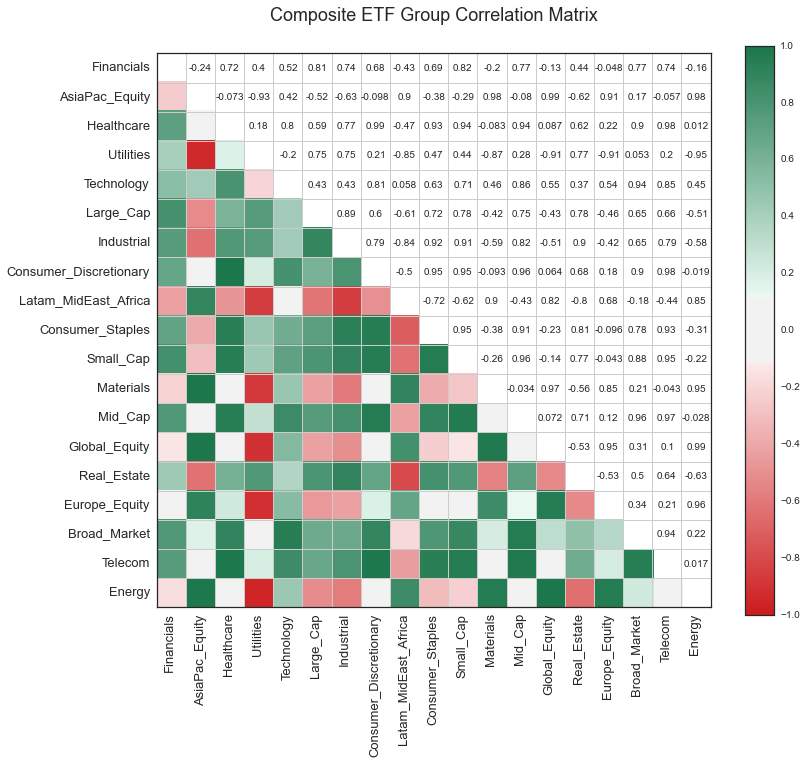

In [8]:
# ================================================================== #
# correlation matrix of composite ETF groups' risk adjusted returns
cor = risk_rets.corr()

# ~~ plot code
f, ax = plt.subplots(figsize=(12,12))

cmap = sns.diverging_palette(h_neg=12, h_pos=144, s=91, l=44, sep=29, n=12, center='light',as_cmap=True)
sns.corrplot(cor, annot=True, sig_stars=False, diag_names=False, cmap=cmap, ax=ax)
ax.set_title('Composite ETF Group Correlation Matrix', fontsize=18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

f.tight_layout()


In [9]:
# ================================================================== #
# import ICC estimates
frame = p.read_csv( filepath+'Spdr_ICC_est_{}.csv'.format(date_today) , index_col=0 ).dropna()
pre_frame = p.read_csv( filepath+'Spdr_ICC_est_2015-04-11.csv', index_col=0 ).dropna()
# ================================================================== #
# group ICC data by category
f        = frame.copy()
pre_f    = pre_frame[['ETF_ICC_est','Category']]


grp      = f.groupby('Category')
grp_mean = grp.mean().sort('ETF_ICC_est', ascending=False)

pre_grp  = pre_f.groupby('Category')
pre_grp_mean = pre_grp.mean().sort('ETF_ICC_est', ascending=False) 

grp_mean = p.DataFrame( np.round( grp_mean['ETF_ICC_est'], 4 ) )
grp_mean['rank'] = grp_mean.rank(ascending=False)
grp_mean['previous ETF ICC est'] = np.round( pre_grp_mean, 4 )
grp_mean['previous ICC est Rank'] = pre_grp_mean.rank(ascending=False)
import qgrid
qgrid.nbinstall()
qgrid.show_grid(grp_mean, remote_js=True)

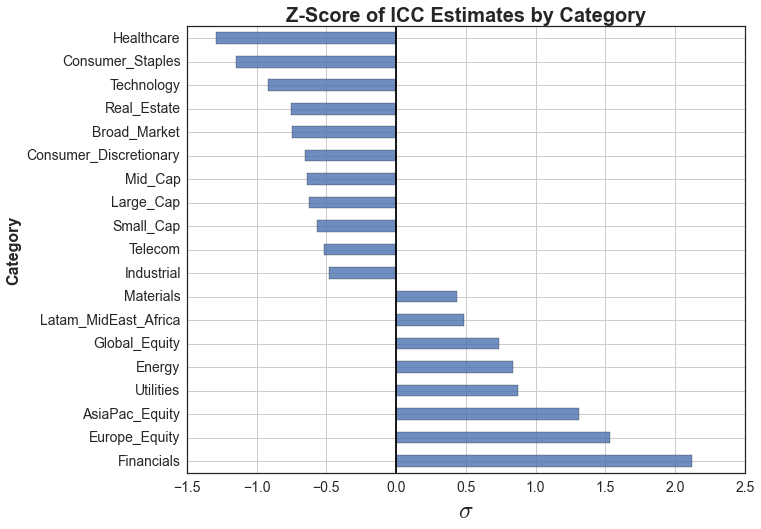

In [10]:
def z_score(df):
    return ( df - df.mean() ) / df.std()

#z_grp = (grp_mean - grp_mean.mean()) / grp_mean.std()
z_grp = z_score(grp_mean['ETF_ICC_est'])

plt.figure()
size = (10, 8)
z_grp.plot('barh', figsize=size, alpha=.8)
plt.axvline(0, color='k')
plt.title('Z-Score of ICC Estimates by Category', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24)
plt.ylabel('Category', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)


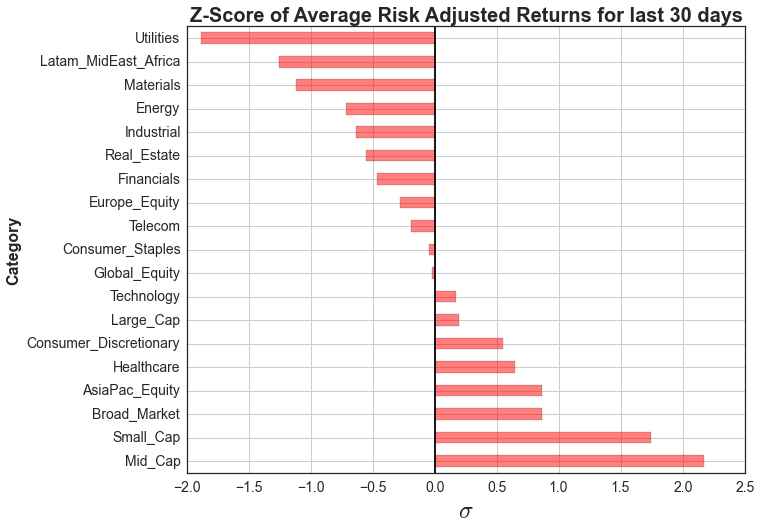

In [11]:
# last 30 days average category risk adjusted returns
date_mask = date_today - 30 * BDay()
l_30 = risk_rets.ix[date_mask:].mean().order(ascending=False) 
l_30

# z scored and plotted
z_l_30 = z_score(l_30)

plt.figure()
z_l_30.plot('barh', figsize=size, color='r', alpha=.5)
plt.axvline(0, color='k')
plt.title('Z-Score of Average Risk Adjusted Returns for last 30 days', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24)
plt.ylabel('Category', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)

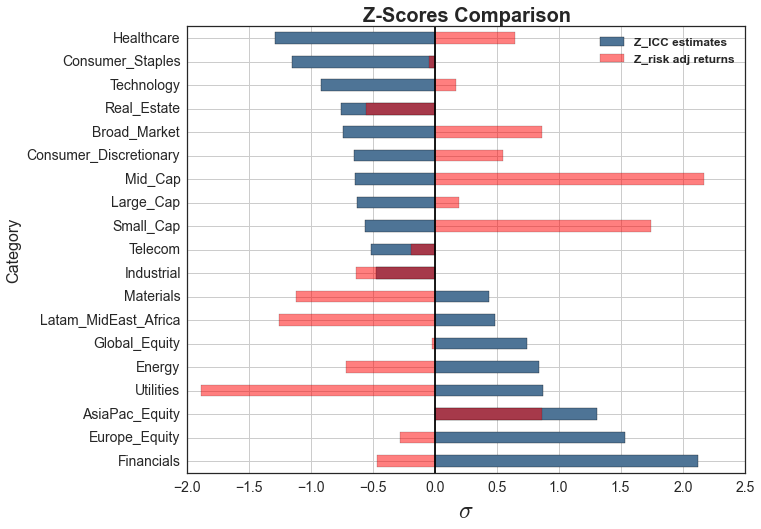

In [12]:
z_data = p.DataFrame()
z_data['Z_ICC estimates'] = z_grp
z_data['Z_risk adj returns'] = z_l_30
# z_data.head()

cadet_blue = '#4e7496'

fig = plt.figure()
with p.plot_params.use('x_compat', True):
    z_data['Z_ICC estimates'].plot('barh', figsize=size, color=cadet_blue)
    z_data['Z_risk adj returns'].plot('barh',figsize=size, color='r', alpha=.5)
plt.axvline(0, color='k')
plt.title('Z-Scores Comparison', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24, fontweight='demibold')
plt.ylabel('Category', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc='best', prop={'weight':'demibold','size':12})

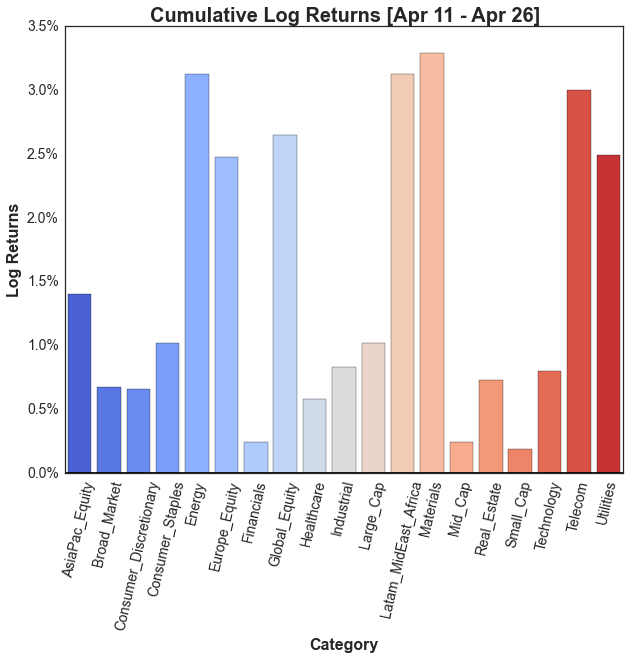

In [13]:
# ================================================================== #
# construct dataframe and proper multi index
log_rets_recent = np.log( px.ix['4/11/2015':] / px.ix['4/11/2015':].shift(1) ).dropna()

lrets_recent = log_rets_recent.T.copy()
lrets_recent.index.name = 'ETF'
lrets_recent['Category'] = p.Series()

for cat_key, etf_val in cat.items():
    for val in etf_val:
        if val in lrets_recent.index:
            idx_loc = lrets_recent.index.get_loc(val)
            lrets_recent.ix[idx_loc,'Category'] = cat_key
        else:
            pass

lrets_recent.set_index('Category', append=True, inplace=True)
lrets_recent = lrets_recent.swaplevel('ETF','Category').sortlevel('Category')
lrets_recent.head()       

# ================================================================== #
# cumulative returns of ETF's
cum_rets_recent = lrets_recent.groupby(level='Category').cumsum(axis=1)
cum_rets_recent.head();

# ================================================================== #
# composite groupings of cumulative ETF returns (equally weighted intra-category mean returns)
composite_rets_recent = p.DataFrame()
for label in cat.keys():
    composite_rets_recent[label] = cum_rets_recent.ix[label].mean(axis=0) # equal weighted mean
    
crr = np.round(composite_rets_recent.copy(),4) # rounding
#fig = plt.figure()
#comp_rets_recent.ix[-1:].plot(kind='bar', figsize=size)
#comp_rets_recent
#crr = crr.reset_index()
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import matplotlib
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)



plt.show()
f = plt.figure(figsize=size)
# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)
#bar_rets = p.melt(crr)
bar_rets = crr.ix[-1:].T.sort('2015-04-24')
bar_rets = bar_rets.reset_index()
bar_rets = p.melt(bar_rets, id_vars='index')
plt.xticks(rotation=77)
plt.axhline(0, color='k')
plt.title('Cumulative Log Returns [Apr 11 - Apr 26]', fontsize=20, fontweight='demibold')
sns.barplot( x=bar_rets['index'],y=bar_rets.value, data=bar_rets, palette='coolwarm')
plt.xlabel('Category', fontsize=16, fontweight='demibold')
plt.ylabel('Log Returns', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)


In [14]:
br = crr.ix[-1:].T.sort('2015-04-24')
br['rank'] = crr.ix[-1:].T.sort('2015-04-24').rank(method='dense',ascending=False)
cols = ['Cum. log returns [4.11-4.26]','rank']
sortd = br.sort('rank',ascending=True)
sortd.columns = cols
sortd.index.name = 'Category'
qgrid.show_grid(sortd, remote_js=True)


### Previous potential Long Positions:
___
 - **Europe_Equity**  
 - **Financials** 
 - **Utilities** 
 
### Previous potential Short Positions:
___
 - **Mid Caps** 
 - **Small Caps**
 - **Healthcare**


# Evaluation
---
Over the past 2 weeks of trading the ranked returns of the **potential long positions** are as follows:

 - Europe Equity (6/16)
 - Finanicals (15/16) *`tie`*
 - Utilities (5/16)
 
The ranked returns of **potential short positions** are as follows:

 - Mid Caps (15/16) *`tie`*
 - Small Caps (16/16)
 - Healthcare (14/16) 

# Interpretation
---
This is a better result than I anticipated. Using the `ICC` model as a guide we were able to identify some asymmetric trading opportunities. For long positions 2 out of 3 composite sectors finished in the top 3rd of ranked returns while *all* short positions finished in the bottom 5th of ranked returns. Logically this is the result we would expect however, the difference between expectation and reality is often unexpected.


_I conclude this analysis with the disclaimer that these calculations are presented `"as is"` and the data was aggregated from several sources. I recommend doing your own due diligence before taking any investment action and to stay within your personal risk/return objectives._ 

_I expect to refine this model as necessary to improve its utility as a macro valuation tool._ 


####**For comments, questions, and feedback contact me via:**
####email:   **`bcr@blackarbs.com`** 
####twitter: **`@blackarbsCEO`**
___

_**Data Sources:** [Yahoo Finance](http://finance.yahoo.com/), [S&P SPDR ETFs](https://www.spdrs.com/product/)_<br />_**Acknowledgements:** Ipython Notebook styling modded from Plotly and Cam Davidson-Pilon custom CSS_

In [15]:
from IPython.core.display import HTML
import requests
styles = requests.get("https://raw.githubusercontent.com/BlackArbsCEO/BlackArbsCEO.github.io/Equity-Analysis/Equity%20Analysis/custom.css")
HTML(styles.text)

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')